In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/thesis/Dataset (S/validation/labels/0566.png
/kaggle/input/thesis/Dataset (S/validation/labels/0133.png
/kaggle/input/thesis/Dataset (S/validation/labels/0006.png
/kaggle/input/thesis/Dataset (S/validation/labels/0516.png
/kaggle/input/thesis/Dataset (S/validation/labels/0003.png
/kaggle/input/thesis/Dataset (S/validation/labels/0217.png
/kaggle/input/thesis/Dataset (S/validation/labels/0816.png
/kaggle/input/thesis/Dataset (S/validation/labels/0337.png
/kaggle/input/thesis/Dataset (S/validation/labels/0835.png
/kaggle/input/thesis/Dataset (S/validation/labels/0096.png
/kaggle/input/thesis/Dataset (S/validation/labels/0451.png
/kaggle/input/thesis/Dataset (S/validation/labels/0301.png
/kaggle/input/thesis/Dataset (S/validation/labels/0947.png
/kaggle/input/thesis/Dataset (S/validation/labels/0405.png
/kaggle/input/thesis/Dataset (S/validation/labels/0341.png
/kaggle/input/thesis/Dataset (S/validation/labels/0208.png
/kaggle/input/thesis/Dataset (S/validation/labels/0369.p

In [2]:
# === Cell 1: Cài & import thư viện cơ bản ===
!pip install -q segmentation-models-pytorch albumentations timm

import os, cv2, gc, random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

torch.manual_seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ Device:", DEVICE)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ Device: cuda


In [3]:
# === Cell 2: Load dataset & tạo train/val pairs ===
ROOT = "/kaggle/input/thesis"
for root, dirs, files in os.walk(ROOT):
    if root.endswith("/train/images"):
        DATA_DIR = root.rsplit("/train/images", 1)[0]
print("Using DATA_DIR:", DATA_DIR)

def get_pairs(split):
    img_dir = os.path.join(DATA_DIR, split, "images")
    mask_dir = os.path.join(DATA_DIR, split, "labels")
    imgs = sorted(glob(os.path.join(img_dir, "*")))
    pairs = [(i, os.path.join(mask_dir, os.path.basename(i))) for i in imgs]
    print(f"{split}: {len(pairs)} samples")
    return pairs

train_pairs = get_pairs("train")
val_pairs = get_pairs("validation")


Using DATA_DIR: /kaggle/input/thesis/Dataset (S
train: 810 samples
validation: 200 samples


In [4]:
# thay thế
# Cell: RGB+Cr (+ CLAHE) augmentation pipeline + Cr visualization

import gc, cv2, random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

CFG_IMG = 512
CFG_BATCH = 2
NUM_WORKERS = 2   # nếu lỗi DataLoader, đổi tạm về 0

# 1️⃣ Hàm thêm kênh Cr (YCrCb) – trả về ndarray (H,W,4)
def add_cr_channel(image, **kwargs):
    """
    Input:  image RGB đã qua augment (H,W,3)
    Output: image (H,W,4) với kênh thứ 4 là Cr (nhấn mạnh vùng đỏ / loét)
    """
    ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    _, cr, _ = cv2.split(ycrcb)
    image_4ch = np.dstack([image, cr])
    return image_4ch

# 2️⃣ Augmentation cho TRAIN: hình học + CLAHE + màu + biến dạng + Cr
train_aug = A.Compose([
    # Hình học
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.4),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.05,
        rotate_limit=180,
        border_mode=cv2.BORDER_REFLECT,
        p=0.5
    ),

    # Tăng local contrast (CLAHE) trước khi tính Cr
    A.CLAHE(clip_limit=(2.0, 4.0), tile_grid_size=(8, 8), p=0.4),

    # Màu sắc / ánh sáng
    A.RandomBrightnessContrast(p=0.3),
    A.HueSaturationValue(p=0.3),
    A.RandomGamma(p=0.25),

    # Biến dạng mềm
    A.ElasticTransform(alpha=40, sigma=5, p=0.25),
    A.GridDistortion(p=0.2),
    A.GaussianBlur(blur_limit=3, p=0.2),

    # 🔴 Color-space enhancement: thêm kênh Cr
    A.Lambda(image=add_cr_channel, p=1.0),

    # Resize + Normalize 4 kênh + Tensor
    A.Resize(CFG_IMG, CFG_IMG),
    A.Normalize(
        mean=(0.485, 0.456, 0.406, 0.5),
        std=(0.229, 0.224, 0.225, 0.25)
    ),
    ToTensorV2(),
])

# 3️⃣ Augmentation cho VAL: chỉ RGB+Cr + resize + normalize (không random)
val_aug = A.Compose([
    A.Lambda(image=add_cr_channel, p=1.0),
    A.Resize(CFG_IMG, CFG_IMG),
    A.Normalize(
        mean=(0.485, 0.456, 0.406, 0.5),
        std=(0.229, 0.224, 0.225, 0.25)
    ),
    ToTensorV2(),
])

# 4️⃣ Dataset dùng RGB+Cr
class DFUSegCR(Dataset):
    def __init__(self, pairs, transform=None):
        self.pairs = pairs
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        ip, mp = self.pairs[idx]
        img = cv2.cvtColor(cv2.imread(ip), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mp, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype("float32")

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img_t = aug["image"]              # (4, H, W)
            mask_t = aug["mask"].unsqueeze(0) # (1, H, W)
        else:
            img_4ch = add_cr_channel(img)
            img_4ch = cv2.resize(img_4ch, (CFG_IMG, CFG_IMG))
            mask_r  = cv2.resize(mask,  (CFG_IMG, CFG_IMG))
            img_t = torch.from_numpy(img_4ch.transpose(2,0,1)).float()
            mask_t = torch.from_numpy(mask_r).unsqueeze(0).float()

        return img_t, mask_t

# 5️⃣ Tạo DataLoader từ train_pairs, val_pairs (đã được định nghĩa ở cell trước)
train_ds = DFUSegCR(train_pairs, transform=train_aug)
val_ds   = DFUSegCR(val_pairs,   transform=val_aug)

train_loader = DataLoader(train_ds, batch_size=CFG_BATCH, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=CFG_BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print(f"✅ RGB+Cr+CLAHE Dataset ready | Train: {len(train_ds)} | Val: {len(val_ds)}")

# Test 1 batch để đảm bảo pipeline ổn
xb, yb = next(iter(train_loader))
print("Sample batch shape - images:", xb.shape, "| masks:", yb.shape)


✅ RGB+Cr+CLAHE Dataset ready | Train: 810 | Val: 200


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Sample batch shape - images: torch.Size([2, 4, 512, 512]) | masks: torch.Size([2, 1, 512, 512])


/tmp/ipykernel_19/983163763.py:82: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



[SegFormer-B3 RGB+Cr+CLAHE] Epoch 1/80


Train SegFormer-B3 (RGB+Cr+CLAHE):   0%|          | 0/405 [00:00<?, ?it/s]/tmp/ipykernel_19/983163763.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Val SegFormer-B3 (RGB+Cr+CLAHE):   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_19/983163763.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Loss 1.1825/0.9845 | Dice 0.2186/0.4052 | IoU 0.1510/0.3121
✅ New best Val Dice: 0.4052 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 2/80


Loss 0.8781/0.8456 | Dice 0.4031/0.3706 | IoU 0.2976/0.2868

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 3/80


Loss 0.6747/0.5510 | Dice 0.4861/0.5901 | IoU 0.3727/0.4673
✅ New best Val Dice: 0.5901 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 4/80


Loss 0.5529/0.4698 | Dice 0.5475/0.6188 | IoU 0.4270/0.4975
✅ New best Val Dice: 0.6188 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 5/80


Loss 0.4912/0.4245 | Dice 0.5860/0.6479 | IoU 0.4653/0.5319
✅ New best Val Dice: 0.6479 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 6/80


Loss 0.4474/0.3586 | Dice 0.6190/0.6982 | IoU 0.4966/0.5838
✅ New best Val Dice: 0.6982 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 7/80


Loss 0.4132/0.3658 | Dice 0.6450/0.6786 | IoU 0.5252/0.5714

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 8/80


Loss 0.3985/0.3384 | Dice 0.6580/0.7107 | IoU 0.5386/0.6037
✅ New best Val Dice: 0.7107 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 9/80


Loss 0.3814/0.3458 | Dice 0.6709/0.7014 | IoU 0.5554/0.5962

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 10/80


Loss 0.3628/0.3106 | Dice 0.6867/0.7238 | IoU 0.5725/0.6209
✅ New best Val Dice: 0.7238 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 11/80


Loss 0.3541/0.3194 | Dice 0.6912/0.7175 | IoU 0.5772/0.6146

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 12/80


Loss 0.3347/0.3121 | Dice 0.7134/0.7304 | IoU 0.6008/0.6315
✅ New best Val Dice: 0.7304 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 13/80


Loss 0.3336/0.2869 | Dice 0.7119/0.7439 | IoU 0.6011/0.6482
✅ New best Val Dice: 0.7439 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 14/80


Loss 0.3169/0.2835 | Dice 0.7282/0.7476 | IoU 0.6187/0.6468
✅ New best Val Dice: 0.7476 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 15/80


Loss 0.3273/0.3255 | Dice 0.7133/0.7162 | IoU 0.6034/0.6213

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 16/80


Loss 0.3301/0.2801 | Dice 0.7132/0.7492 | IoU 0.6030/0.6518
✅ New best Val Dice: 0.7492 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 17/80


Loss 0.3050/0.2777 | Dice 0.7369/0.7497 | IoU 0.6287/0.6505
✅ New best Val Dice: 0.7497 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 18/80


Loss 0.3054/0.2770 | Dice 0.7356/0.7515 | IoU 0.6282/0.6519
✅ New best Val Dice: 0.7515 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 19/80


Loss 0.2949/0.2922 | Dice 0.7455/0.7425 | IoU 0.6399/0.6510

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 20/80


Loss 0.2951/0.2641 | Dice 0.7445/0.7667 | IoU 0.6378/0.6689
✅ New best Val Dice: 0.7667 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 21/80


Loss 0.2919/0.2529 | Dice 0.7471/0.7729 | IoU 0.6423/0.6777
✅ New best Val Dice: 0.7729 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 22/80


Loss 0.2903/0.2654 | Dice 0.7462/0.7671 | IoU 0.6401/0.6705

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 23/80


Loss 0.2693/0.2773 | Dice 0.7638/0.7526 | IoU 0.6596/0.6550

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 24/80


Loss 0.2721/0.2613 | Dice 0.7625/0.7658 | IoU 0.6598/0.6717

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 25/80


Loss 0.2852/0.2794 | Dice 0.7514/0.7471 | IoU 0.6470/0.6469

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 26/80


Loss 0.2637/0.2786 | Dice 0.7682/0.7544 | IoU 0.6637/0.6584

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 27/80


Loss 0.2695/0.2721 | Dice 0.7629/0.7556 | IoU 0.6601/0.6584

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 28/80


Loss 0.2637/0.2546 | Dice 0.7703/0.7770 | IoU 0.6681/0.6847
✅ New best Val Dice: 0.7770 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 29/80


Loss 0.2516/0.2256 | Dice 0.7803/0.7957 | IoU 0.6811/0.7052
✅ New best Val Dice: 0.7957 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 30/80


Loss 0.2491/0.2591 | Dice 0.7825/0.7721 | IoU 0.6810/0.6797

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 31/80


Loss 0.2489/0.2576 | Dice 0.7811/0.7686 | IoU 0.6809/0.6800

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 32/80


Loss 0.2416/0.2549 | Dice 0.7854/0.7712 | IoU 0.6858/0.6778

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 33/80


Loss 0.2436/0.2367 | Dice 0.7864/0.7856 | IoU 0.6869/0.6957

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 34/80


Loss 0.2434/0.2595 | Dice 0.7849/0.7692 | IoU 0.6889/0.6778

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 35/80


Loss 0.2445/0.2433 | Dice 0.7863/0.7799 | IoU 0.6865/0.6853

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 36/80


Loss 0.2427/0.2774 | Dice 0.7864/0.7598 | IoU 0.6882/0.6659

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 37/80


Loss 0.2391/0.2178 | Dice 0.7868/0.8038 | IoU 0.6896/0.7152
✅ New best Val Dice: 0.8038 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 38/80


Loss 0.2282/0.2221 | Dice 0.7998/0.7999 | IoU 0.7039/0.7120

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 39/80


Loss 0.2273/0.2051 | Dice 0.8014/0.8130 | IoU 0.7056/0.7281
✅ New best Val Dice: 0.8130 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 40/80


Loss 0.2212/0.2107 | Dice 0.8045/0.8084 | IoU 0.7085/0.7222

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 41/80


Loss 0.2354/0.2460 | Dice 0.7921/0.7811 | IoU 0.6958/0.6872

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 42/80


Loss 0.2299/0.2049 | Dice 0.7960/0.8137 | IoU 0.6992/0.7288
✅ New best Val Dice: 0.8137 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 43/80


Loss 0.2200/0.2316 | Dice 0.8050/0.7948 | IoU 0.7102/0.7075

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 44/80


Loss 0.2266/0.2121 | Dice 0.8009/0.8059 | IoU 0.7060/0.7200

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 45/80


Loss 0.2237/0.2085 | Dice 0.8003/0.8106 | IoU 0.7057/0.7238

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 46/80


Loss 0.2204/0.2122 | Dice 0.8034/0.8062 | IoU 0.7086/0.7217

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 47/80


Loss 0.2163/0.2065 | Dice 0.8082/0.8104 | IoU 0.7139/0.7264

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 48/80


Loss 0.2148/0.2123 | Dice 0.8086/0.8070 | IoU 0.7160/0.7231

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 49/80


Loss 0.2178/0.2217 | Dice 0.8095/0.7978 | IoU 0.7157/0.7148

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 50/80


Loss 0.2095/0.2100 | Dice 0.8167/0.8084 | IoU 0.7252/0.7235

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 51/80


Loss 0.2140/0.1937 | Dice 0.8128/0.8232 | IoU 0.7214/0.7391
✅ New best Val Dice: 0.8232 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 52/80


Loss 0.2065/0.2040 | Dice 0.8168/0.8148 | IoU 0.7255/0.7293

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 53/80


Loss 0.2184/0.2049 | Dice 0.8089/0.8133 | IoU 0.7171/0.7268

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 54/80


Loss 0.2022/0.2324 | Dice 0.8198/0.7917 | IoU 0.7275/0.7034

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 55/80


Loss 0.2056/0.2220 | Dice 0.8159/0.8013 | IoU 0.7246/0.7186

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 56/80


Loss 0.2075/0.2018 | Dice 0.8178/0.8161 | IoU 0.7256/0.7315

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 57/80


Loss 0.2008/0.1942 | Dice 0.8217/0.8223 | IoU 0.7335/0.7382

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 58/80


Loss 0.2002/0.2077 | Dice 0.8238/0.8109 | IoU 0.7332/0.7297

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 59/80


Loss 0.1966/0.1967 | Dice 0.8238/0.8206 | IoU 0.7348/0.7392

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 60/80


Loss 0.2208/0.2199 | Dice 0.8054/0.8006 | IoU 0.7129/0.7154

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 61/80


Loss 0.2001/0.2258 | Dice 0.8233/0.7954 | IoU 0.7344/0.7093

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 62/80


Loss 0.2008/0.2157 | Dice 0.8205/0.8069 | IoU 0.7305/0.7235

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 63/80


Loss 0.2027/0.2004 | Dice 0.8209/0.8171 | IoU 0.7299/0.7342

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 64/80


Loss 0.1930/0.2231 | Dice 0.8288/0.8023 | IoU 0.7406/0.7137

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 65/80


Loss 0.1986/0.2054 | Dice 0.8229/0.8125 | IoU 0.7339/0.7295

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 66/80


Loss 0.2081/0.2145 | Dice 0.8155/0.8050 | IoU 0.7251/0.7207

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 67/80


Loss 0.1911/0.2249 | Dice 0.8285/0.7960 | IoU 0.7393/0.7098

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 68/80


Loss 0.1973/0.2041 | Dice 0.8259/0.8135 | IoU 0.7366/0.7316

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 69/80


Loss 0.1927/0.1943 | Dice 0.8309/0.8221 | IoU 0.7426/0.7409

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 70/80


Loss 0.1922/0.1939 | Dice 0.8322/0.8238 | IoU 0.7440/0.7408
✅ New best Val Dice: 0.8238 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 71/80


Loss 0.1855/0.1856 | Dice 0.8362/0.8297 | IoU 0.7486/0.7533
✅ New best Val Dice: 0.8297 (model saved)

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 72/80


Loss 0.1931/0.2086 | Dice 0.8264/0.8103 | IoU 0.7376/0.7291

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 73/80


Loss 0.1982/0.2040 | Dice 0.8265/0.8142 | IoU 0.7379/0.7353

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 74/80


Loss 0.1986/0.1934 | Dice 0.8277/0.8224 | IoU 0.7395/0.7431

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 75/80


Loss 0.1926/0.2076 | Dice 0.8271/0.8109 | IoU 0.7408/0.7250

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 76/80


Loss 0.1915/0.2095 | Dice 0.8281/0.8101 | IoU 0.7407/0.7266

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 77/80


Loss 0.1898/0.2068 | Dice 0.8311/0.8117 | IoU 0.7443/0.7274

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 78/80


Loss 0.1807/0.1914 | Dice 0.8415/0.8269 | IoU 0.7558/0.7475

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 79/80


Loss 0.1775/0.1903 | Dice 0.8420/0.8258 | IoU 0.7570/0.7465

[SegFormer-B3 RGB+Cr+CLAHE] Epoch 80/80


Loss 0.1998/0.2132 | Dice 0.8230/0.8076 | IoU 0.7342/0.7212

✅ Done. Best Val Dice (SegFormer-B3 RGB+Cr+CLAHE): 0.8297


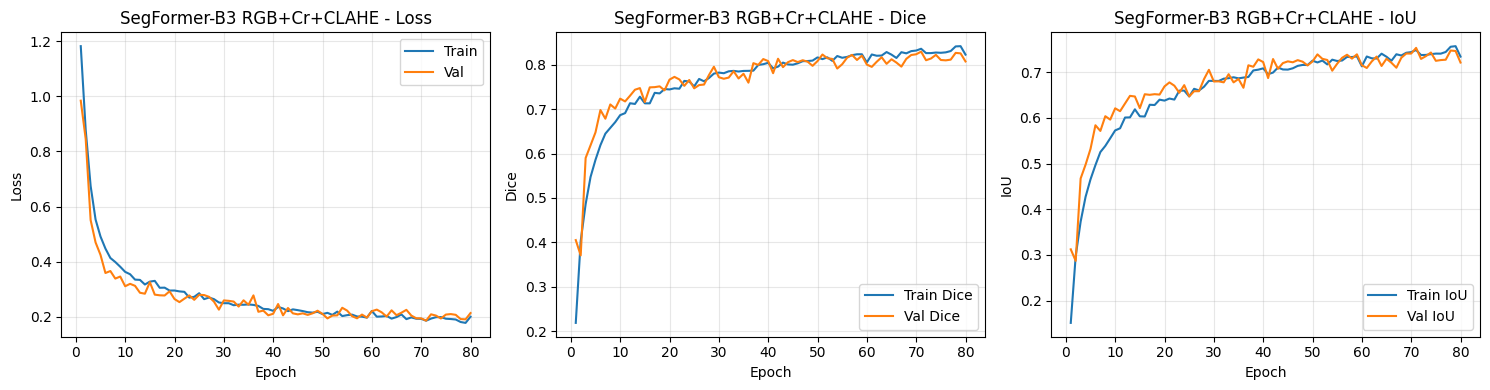

In [5]:
# thay thế
# Cell: Train SegFormer-B3 (RGB + Cr + CLAHE) để đánh giá Dice/IoU

import gc
import torch
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler

# train_loader, val_loader phải đến từ cell RGB+Cr+CLAHE (4-channel)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

EPOCHS_SEG_CLAHE_CR = 80    # giữ 80 epoch cho công bằng
LR_SEG_CLAHE_CR = 1e-4

# ===== Metric & loss =====
def dice_coef(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    inter = (pred * target).sum((2,3))
    union = pred.sum((2,3)) + target.sum((2,3))
    return ((2*inter + smooth)/(union + smooth)).mean().item()

def iou_coef(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    inter = (pred * target).sum((2,3))
    union = (pred + target - pred*target).sum((2,3))
    return ((inter + smooth)/(union + smooth)).mean().item()

def bce_dice_loss(pred, target, smooth=1e-5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    ps = torch.sigmoid(pred)
    inter = (ps * target).sum((2,3))
    union = ps.sum((2,3)) + target.sum((2,3))
    dice = 1 - ((2*inter + smooth)/(union + smooth))
    return bce + dice.mean()

# ===== Train/Val loops (có AMP) =====
def train_one_epoch(model, loader, opt, scaler):
    model.train(); tl=td=ti=0.0
    for x,y in tqdm(loader, desc="Train SegFormer-B3 (RGB+Cr+CLAHE)", leave=False):
        x,y = x.to(DEVICE), y.to(DEVICE)
        opt.zero_grad()
        with autocast():
            o = model(x)
            l = bce_dice_loss(o,y)
        scaler.scale(l).backward()
        scaler.step(opt)
        scaler.update()
        tl += l.item()
        td += dice_coef(o,y)
        ti += iou_coef(o,y)
    n = len(loader)
    return tl/n, td/n, ti/n

@torch.no_grad()
def valid_one_epoch(model, loader):
    model.eval(); vl=vd=vi=0.0
    for x,y in tqdm(loader, desc="Val SegFormer-B3 (RGB+Cr+CLAHE)", leave=False):
        x,y = x.to(DEVICE), y.to(DEVICE)
        with autocast():
            o = model(x)
            l = bce_dice_loss(o,y)
        vl += l.item()
        vd += dice_coef(o,y)
        vi += iou_coef(o,y)
    n = len(loader)
    return vl/n, vd/n, vi/n

# ===== Model =====
segformer_clahe_cr = smp.Unet(
    encoder_name="mit_b3",      # SegFormer backbone
    encoder_weights=None,       # 4-channel => không dùng pretrained
    in_channels=4,
    classes=1,
).to(DEVICE)

opt = torch.optim.Adam(segformer_clahe_cr.parameters(), lr=LR_SEG_CLAHE_CR)
scaler = GradScaler()

history = {
    "train_loss":[], "val_loss":[],
    "train_dice":[], "val_dice":[],
    "train_iou":[],  "val_iou":[]
}
best_dice = 0.0

# ===== Training loop =====
for e in range(1, EPOCHS_SEG_CLAHE_CR + 1):
    print(f"\n[SegFormer-B3 RGB+Cr+CLAHE] Epoch {e}/{EPOCHS_SEG_CLAHE_CR}")
    torch.cuda.empty_cache(); gc.collect()

    trl,trd,tri = train_one_epoch(segformer_clahe_cr, train_loader, opt, scaler)
    vl,vd,vi    = valid_one_epoch(segformer_clahe_cr, val_loader)

    history["train_loss"].append(trl); history["val_loss"].append(vl)
    history["train_dice"].append(trd); history["val_dice"].append(vd)
    history["train_iou"].append(tri);  history["val_iou"].append(vi)

    print(f"Loss {trl:.4f}/{vl:.4f} | Dice {trd:.4f}/{vd:.4f} | IoU {tri:.4f}/{vi:.4f}")

    if vd > best_dice:
        best_dice = vd
        torch.save(segformer_clahe_cr.state_dict(), "SegFormerB3_RGB_Cr_CLAHE_best.pth")
        print(f"✅ New best Val Dice: {best_dice:.4f} (model saved)")

print(f"\n✅ Done. Best Val Dice (SegFormer-B3 RGB+Cr+CLAHE): {best_dice:.4f}")

# ===== Plot learning curves =====
epochs = range(1, len(history["train_loss"]) + 1)
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(epochs, history["train_loss"], label="Train")
plt.plot(epochs, history["val_loss"], label="Val")
plt.title("SegFormer-B3 RGB+Cr+CLAHE - Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(alpha=.3)

plt.subplot(1,3,2)
plt.plot(epochs, history["train_dice"], label="Train Dice")
plt.plot(epochs, history["val_dice"], label="Val Dice")
plt.title("SegFormer-B3 RGB+Cr+CLAHE - Dice")
plt.xlabel("Epoch"); plt.ylabel("Dice")
plt.legend(); plt.grid(alpha=.3)

plt.subplot(1,3,3)
plt.plot(epochs, history["train_iou"], label="Train IoU")
plt.plot(epochs, history["val_iou"], label="Val IoU")
plt.title("SegFormer-B3 RGB+Cr+CLAHE - IoU")
plt.xlabel("Epoch"); plt.ylabel("IoU")
plt.legend(); plt.grid(alpha=.3)

plt.tight_layout()
plt.show()
